# Q-GAN: (Q-Net) + GAN (G-Net and D-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[-0.03074888 -0.19904344  0.0167938   0.24935339] 0 1.0 False {}
state, action, reward, done, info
[-0.03472975 -0.00416529  0.02178086 -0.03798547] 1 1.0 False {}
state, action, reward, done, info
[-0.03481306  0.19063766  0.02102116 -0.32371752] 1 1.0 False {}
state, action, reward, done, info
[-0.0310003  -0.00477721  0.0145468  -0.02448021] 0 1.0 False {}
state, action, reward, done, info
[-0.03109585  0.19013314  0.0140572  -0.31253819] 1 1.0 False {}
state, action, reward, done, info
[-0.02729319  0.38505203  0.00780644 -0.60075497] 1 1.0 False {}
state, action, reward, done, info
[-0.01959214  0.58006391 -0.00420866 -0.8909688 ] 1 1.0 False {}
state, action, reward, done, info
[-0.00799087  0.77524271 -0.02202804 -1.18497175] 1 1.0 False {}
state, action, reward, done, info
[ 0.00751399  0.97064336 -0.04572747 -1.48447734] 1 1.0 False {}
state, action, reward, done, info
[ 0.02692686  1.16629201 -0.07541702 -1.79108273] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.1662920088672648 -1.791082728620816


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Next states given
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # TargetQs/values
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, next_states, actions, targetQs

In [7]:
# Q: Qfunction/Encoder
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('qfunction', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
# G: Generator/Decoder: actions can be given actions, generated actions
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        #predictions = tf.sigmoid(logits)

        # return next_states_logits
        return logits

In [9]:
# D: Descriminator/Reward function
def discriminator(states, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # return reward logits
        return logits

In [10]:
def model_loss(states, action_size, hidden_size, actions, targetQs, state_size, next_states, alpha=0.1):
    # DQN: Q-learning - Bellman equations: loss (targetQ - Q)^2
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_real = tf.one_hot(actions, action_size)
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # GAN: Generate next states
    actions_fake = tf.nn.softmax(actions_logits)
    next_states_logits = generator(actions=actions_fake, state_size=state_size, hidden_size=hidden_size)
    
    # GAN: Discriminate between fake and real
    next_states_fake = tf.sigmoid(x=next_states_logits)
    d_logits_fake = discriminator(states=next_states_fake, hidden_size=hidden_size, reuse=False)
    next_states_real = tf.sigmoid(x=next_states) 
    d_logits_real = discriminator(states=next_states_real, hidden_size=hidden_size, reuse=True)

    # GAN: Adverserial training - D-learning
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    # GAN: Adverserial training - G-learning
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Rewards fake/real
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return actions_logits, q_loss, d_loss, g_loss, rewards_fake, rewards_real

In [11]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param g_loss: Generator/Decoder loss Tensor for next state prediction
    :param d_loss: Discriminator/Reward loss Tensor for current reward function
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at
    g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return q_opt, g_opt, d_opt

In [12]:
class DQAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.d_loss, self.g_loss, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, 
            states=self.states, next_states=self.next_states, actions=self.actions, targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, q_loss=self.q_loss, 
                                                       learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [30]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 2000               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [31]:
tf.reset_default_graph()

model = DQAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [32]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [33]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, rewards_fake_list, rewards_real_list = [], [], []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, rewards_fake_mean, rewards_real_mean = 0, 0, 0
        d_loss, g_loss, q_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Average reward real: {}'.format(rewards_real_mean),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions}
            rewards_fake, rewards_real = sess.run([model.rewards_fake, model.rewards_real], feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake and real rewards or rewarded generated/given actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            rewards_real_mean = np.mean(rewards_real.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions, 
                         model.targetQs: targetQs}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/Q-GAN-cartpole.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 17.0 Average reward fake: 0.4733968675136566 Average reward real: 0.5066425204277039 Training q_loss: 0.4849 Training g_loss: 0.7479 Training d_loss: 1.3244 Explore P: 0.9983
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 30.0 Average reward fake: 0.5069016814231873 Average reward real: 0.48017579317092896 Training q_loss: 0.5890 Training g_loss: 0.6794 Training d_loss: 1.4512 Explore P: 0.9954
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 41.0 Average reward fake: 0.4231354296207428 Average reward real: 0.548786997795105 Training q_loss: 3.1925 Training g_loss: 0.8602 Training d_loss: 1.1780 Explore P: 0.9913


-------------------------------------------------------------------------------
Episode: 23 Total reward: 10.0 Average reward fake: 0.2908213138580322 Average reward real: 0.5288034677505493 Training q_loss: 452.6029 Training g_loss: 1.2353 Training d_loss: 1.0281 Explore P: 0.9450
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 24 Total reward: 25.0 Average reward fake: 0.4070822596549988 Average reward real: 0.4201062321662903 Training q_loss: 271.5314 Training g_loss: 0.8982 Training d_loss: 1.4704 Explore P: 0.9426
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 25 Total reward: 8.0 Average reward fake: 0.45462483167648315 Average reward real: 0.43087559938430786 Training q_loss: 1.0712 Training g_loss: 0.7884 Training d_loss: 1.5327 Explore P:

-------------------------------------------------------------------------------
Episode: 46 Total reward: 34.0 Average reward fake: 0.49558648467063904 Average reward real: 0.5365912318229675 Training q_loss: 20.4550 Training g_loss: 0.7088 Training d_loss: 1.3271 Explore P: 0.8897
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 47 Total reward: 91.0 Average reward fake: 0.5145807266235352 Average reward real: 0.5224341154098511 Training q_loss: 3.0706 Training g_loss: 0.6651 Training d_loss: 1.3774 Explore P: 0.8818
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 48 Total reward: 17.0 Average reward fake: 0.5011904239654541 Average reward real: 0.4957202076911926 Training q_loss: 2.2532 Training g_loss: 0.6915 Training d_loss: 1.4063 Explore P: 0.

-------------------------------------------------------------------------------
Episode: 69 Total reward: 34.0 Average reward fake: 0.5276035666465759 Average reward real: 0.5504467487335205 Training q_loss: 42.5767 Training g_loss: 0.6461 Training d_loss: 1.4004 Explore P: 0.8301
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 70 Total reward: 14.0 Average reward fake: 0.4459071755409241 Average reward real: 0.47738438844680786 Training q_loss: 4.4286 Training g_loss: 0.8206 Training d_loss: 1.4387 Explore P: 0.8289
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 71 Total reward: 49.0 Average reward fake: 0.3550422787666321 Average reward real: 0.4648404121398926 Training q_loss: 1.6035 Training g_loss: 1.0406 Training d_loss: 1.4796 Explore P: 0.

-------------------------------------------------------------------------------
Episode: 92 Total reward: 31.0 Average reward fake: 0.4221034646034241 Average reward real: 0.5363606214523315 Training q_loss: 1.9677 Training g_loss: 0.8639 Training d_loss: 1.1912 Explore P: 0.7738
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 48.0 Average reward fake: 0.4003715515136719 Average reward real: 0.46312838792800903 Training q_loss: 64.7181 Training g_loss: 0.9172 Training d_loss: 1.3117 Explore P: 0.7701
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 47.0 Average reward fake: 0.5002356767654419 Average reward real: 0.5416938066482544 Training q_loss: 2.7216 Training g_loss: 0.8781 Training d_loss: 1.5429 Explore P: 0.

-------------------------------------------------------------------------------
Episode: 115 Total reward: 27.0 Average reward fake: 0.4213469922542572 Average reward real: 0.5308651924133301 Training q_loss: 23.1246 Training g_loss: 0.8656 Training d_loss: 1.2019 Explore P: 0.7137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 116 Total reward: 21.0 Average reward fake: 0.5101144909858704 Average reward real: 0.5173164010047913 Training q_loss: 1.9128 Training g_loss: 0.6739 Training d_loss: 1.3902 Explore P: 0.7123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 117 Total reward: 25.0 Average reward fake: 0.48099440336227417 Average reward real: 0.5474568605422974 Training q_loss: 3.8323 Training g_loss: 0.7484 Training d_loss: 1.3656 Explore P:

-------------------------------------------------------------------------------
Episode: 138 Total reward: 118.0 Average reward fake: 0.4850695729255676 Average reward real: 0.45123010873794556 Training q_loss: 8.3753 Training g_loss: 0.7255 Training d_loss: 1.5117 Explore P: 0.6123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 139 Total reward: 95.0 Average reward fake: 0.4394541382789612 Average reward real: 0.5440611839294434 Training q_loss: 8.6425 Training g_loss: 0.8236 Training d_loss: 1.1983 Explore P: 0.6066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 140 Total reward: 85.0 Average reward fake: 0.496587336063385 Average reward real: 0.5667728185653687 Training q_loss: 14.6526 Training g_loss: 0.7002 Training d_loss: 1.2843 Explore P:

-------------------------------------------------------------------------------
Episode: 161 Total reward: 53.0 Average reward fake: 0.5991781949996948 Average reward real: 0.5625318288803101 Training q_loss: 29.6861 Training g_loss: 0.5130 Training d_loss: 1.5879 Explore P: 0.4651
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 162 Total reward: 199.0 Average reward fake: 0.4523705840110779 Average reward real: 0.5172311067581177 Training q_loss: 69.8362 Training g_loss: 0.7952 Training d_loss: 1.2772 Explore P: 0.4561
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 163 Total reward: 64.0 Average reward fake: 0.4946669638156891 Average reward real: 0.49602586030960083 Training q_loss: 42.1616 Training g_loss: 0.7067 Training d_loss: 1.4041 Explore

-------------------------------------------------------------------------------
Episode: 184 Total reward: 199.0 Average reward fake: 0.5415980815887451 Average reward real: 0.5367089509963989 Training q_loss: 71.7112 Training g_loss: 0.6133 Training d_loss: 1.4043 Explore P: 0.3116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 185 Total reward: 199.0 Average reward fake: 0.514239490032196 Average reward real: 0.4722348749637604 Training q_loss: 51.0579 Training g_loss: 0.6662 Training d_loss: 1.5092 Explore P: 0.3057
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 186 Total reward: 199.0 Average reward fake: 0.43711382150650024 Average reward real: 0.4993830621242523 Training q_loss: 55.7969 Training g_loss: 0.8390 Training d_loss: 1.3088 Explor

-------------------------------------------------------------------------------
Episode: 207 Total reward: 199.0 Average reward fake: 0.41181880235671997 Average reward real: 0.6715726256370544 Training q_loss: 29.2138 Training g_loss: 0.8901 Training d_loss: 0.9510 Explore P: 0.2011
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 208 Total reward: 199.0 Average reward fake: 0.5006368160247803 Average reward real: 0.4486227035522461 Training q_loss: 1484.3007 Training g_loss: 0.6918 Training d_loss: 1.5037 Explore P: 0.1974
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 199.0 Average reward fake: 0.4521171450614929 Average reward real: 0.49466219544410706 Training q_loss: 24.5008 Training g_loss: 0.7947 Training d_loss: 1.3333 Ex

-------------------------------------------------------------------------------
Episode: 230 Total reward: 185.0 Average reward fake: 0.34853535890579224 Average reward real: 0.48246651887893677 Training q_loss: 8.8062 Training g_loss: 1.0541 Training d_loss: 1.1744 Explore P: 0.1312
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 231 Total reward: 199.0 Average reward fake: 0.5580108761787415 Average reward real: 0.4784781336784363 Training q_loss: 4.2011 Training g_loss: 0.5834 Training d_loss: 1.5757 Explore P: 0.1288
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 232 Total reward: 199.0 Average reward fake: 0.5074760913848877 Average reward real: 0.48133692145347595 Training q_loss: 3.6571 Training g_loss: 0.6784 Training d_loss: 1.4487 Explor

-------------------------------------------------------------------------------
Episode: 253 Total reward: 199.0 Average reward fake: 0.40037599205970764 Average reward real: 0.5644620656967163 Training q_loss: 2.8406 Training g_loss: 0.9152 Training d_loss: 1.1264 Explore P: 0.0867
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 254 Total reward: 199.0 Average reward fake: 0.4932074546813965 Average reward real: 0.41558533906936646 Training q_loss: 4.4222 Training g_loss: 0.7068 Training d_loss: 1.5702 Explore P: 0.0852
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 255 Total reward: 199.0 Average reward fake: 0.6097315549850464 Average reward real: 0.6488297581672668 Training q_loss: 11.4722 Training g_loss: 0.4949 Training d_loss: 1.3838 Explor

-------------------------------------------------------------------------------
Episode: 276 Total reward: 199.0 Average reward fake: 0.4785480499267578 Average reward real: 0.5226576328277588 Training q_loss: 15.0857 Training g_loss: 0.7416 Training d_loss: 1.3202 Explore P: 0.0586
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 277 Total reward: 199.0 Average reward fake: 0.4615965783596039 Average reward real: 0.46382126212120056 Training q_loss: 3.5575 Training g_loss: 0.7733 Training d_loss: 1.4018 Explore P: 0.0576
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 278 Total reward: 199.0 Average reward fake: 0.4040057063102722 Average reward real: 0.4275839924812317 Training q_loss: 1.6738 Training g_loss: 0.9063 Training d_loss: 1.3771 Explore

-------------------------------------------------------------------------------
Episode: 299 Total reward: 199.0 Average reward fake: 0.5528534054756165 Average reward real: 0.40770286321640015 Training q_loss: 163.5520 Training g_loss: 0.5921 Training d_loss: 1.7228 Explore P: 0.0407
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 300 Total reward: 199.0 Average reward fake: 0.4855945110321045 Average reward real: 0.59275883436203 Training q_loss: 3.1404 Training g_loss: 0.7221 Training d_loss: 1.1958 Explore P: 0.0401
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 199.0 Average reward fake: 0.4892759919166565 Average reward real: 0.45675843954086304 Training q_loss: 2.2952 Training g_loss: 0.7148 Training d_loss: 1.4623 Explore

-------------------------------------------------------------------------------
Episode: 322 Total reward: 199.0 Average reward fake: 0.4673364758491516 Average reward real: 0.5013387203216553 Training q_loss: 0.8344 Training g_loss: 0.7611 Training d_loss: 1.3239 Explore P: 0.0296
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 323 Total reward: 188.0 Average reward fake: 0.5479937791824341 Average reward real: 0.5445911288261414 Training q_loss: 0.6844 Training g_loss: 0.6023 Training d_loss: 1.4077 Explore P: 0.0293
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 324 Total reward: 167.0 Average reward fake: 0.5683624744415283 Average reward real: 0.4903012812137604 Training q_loss: 7.5698 Training g_loss: 0.5656 Training d_loss: 1.5990 Explore P

-------------------------------------------------------------------------------
Episode: 345 Total reward: 199.0 Average reward fake: 0.5439531207084656 Average reward real: 0.5139791965484619 Training q_loss: 0.3227 Training g_loss: 0.6092 Training d_loss: 1.4598 Explore P: 0.0228
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 346 Total reward: 192.0 Average reward fake: 0.4889954924583435 Average reward real: 0.4691590368747711 Training q_loss: 2.0415 Training g_loss: 0.7193 Training d_loss: 1.4337 Explore P: 0.0226
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 347 Total reward: 119.0 Average reward fake: 0.5042582154273987 Average reward real: 0.4987606108188629 Training q_loss: 3.4677 Training g_loss: 0.6860 Training d_loss: 1.4078 Explore P

-------------------------------------------------------------------------------
Episode: 368 Total reward: 184.0 Average reward fake: 0.30429697036743164 Average reward real: 0.5422815680503845 Training q_loss: 0.2104 Training g_loss: 1.1906 Training d_loss: 1.0348 Explore P: 0.0184
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 369 Total reward: 199.0 Average reward fake: 0.3731233775615692 Average reward real: 0.5903844237327576 Training q_loss: 2.4653 Training g_loss: 0.9909 Training d_loss: 1.0255 Explore P: 0.0182
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 370 Total reward: 132.0 Average reward fake: 0.5331926941871643 Average reward real: 0.5940283536911011 Training q_loss: 1.1100 Training g_loss: 0.6285 Training d_loss: 1.2843 Explore 

-------------------------------------------------------------------------------
Episode: 391 Total reward: 79.0 Average reward fake: 0.41922202706336975 Average reward real: 0.6700993180274963 Training q_loss: 71.1578 Training g_loss: 0.8694 Training d_loss: 0.9908 Explore P: 0.0164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 392 Total reward: 44.0 Average reward fake: 0.48312902450561523 Average reward real: 0.7762941122055054 Training q_loss: 116.9760 Training g_loss: 0.7836 Training d_loss: 1.0639 Explore P: 0.0164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 393 Total reward: 134.0 Average reward fake: 0.24532437324523926 Average reward real: 0.7989175915718079 Training q_loss: 77.0255 Training g_loss: 2.0330 Training d_loss: 0.7775 Expl

-------------------------------------------------------------------------------
Episode: 414 Total reward: 163.0 Average reward fake: 0.5155926942825317 Average reward real: 0.48661795258522034 Training q_loss: 1.4482 Training g_loss: 0.6807 Training d_loss: 1.4687 Explore P: 0.0142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 415 Total reward: 150.0 Average reward fake: 0.4439142346382141 Average reward real: 0.46615511178970337 Training q_loss: 2.6443 Training g_loss: 0.8120 Training d_loss: 1.3720 Explore P: 0.0142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 416 Total reward: 199.0 Average reward fake: 0.4978065490722656 Average reward real: 0.47711700201034546 Training q_loss: 5.3770 Training g_loss: 0.6978 Training d_loss: 1.4575 Explor

-------------------------------------------------------------------------------
Episode: 437 Total reward: 187.0 Average reward fake: 0.5524574518203735 Average reward real: 0.4620543122291565 Training q_loss: 1.2086 Training g_loss: 0.5934 Training d_loss: 1.5946 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 438 Total reward: 199.0 Average reward fake: 0.46532607078552246 Average reward real: 0.5222019553184509 Training q_loss: 1.1706 Training g_loss: 0.7663 Training d_loss: 1.3339 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 439 Total reward: 199.0 Average reward fake: 0.5279906392097473 Average reward real: 0.43599218130111694 Training q_loss: 2.0525 Training g_loss: 0.6400 Training d_loss: 1.6063 Explore

-------------------------------------------------------------------------------
Episode: 460 Total reward: 199.0 Average reward fake: 0.5428503751754761 Average reward real: 0.5805976986885071 Training q_loss: 2.2917 Training g_loss: 0.6115 Training d_loss: 1.3306 Explore P: 0.0118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 461 Total reward: 199.0 Average reward fake: 0.5042527914047241 Average reward real: 0.5642151832580566 Training q_loss: 1.2115 Training g_loss: 0.6854 Training d_loss: 1.2798 Explore P: 0.0118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 462 Total reward: 199.0 Average reward fake: 0.5018133521080017 Average reward real: 0.4974740147590637 Training q_loss: 0.9812 Training g_loss: 0.6937 Training d_loss: 1.4025 Explore P

-------------------------------------------------------------------------------
Episode: 483 Total reward: 199.0 Average reward fake: 0.5415852665901184 Average reward real: 0.5068497657775879 Training q_loss: 4.3886 Training g_loss: 0.6135 Training d_loss: 1.4746 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 484 Total reward: 130.0 Average reward fake: 0.47612571716308594 Average reward real: 0.5339152812957764 Training q_loss: 12.2539 Training g_loss: 0.7421 Training d_loss: 1.2823 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 485 Total reward: 63.0 Average reward fake: 0.48745808005332947 Average reward real: 0.45371508598327637 Training q_loss: 75.5899 Training g_loss: 0.7186 Training d_loss: 1.4744 Explo

-------------------------------------------------------------------------------
Episode: 507 Total reward: 11.0 Average reward fake: 0.4925708770751953 Average reward real: 0.538152813911438 Training q_loss: 523321.1875 Training g_loss: 0.7081 Training d_loss: 1.3064 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 508 Total reward: 9.0 Average reward fake: 0.4714425206184387 Average reward real: 0.5066877603530884 Training q_loss: 427850.5000 Training g_loss: 0.7520 Training d_loss: 1.3236 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 509 Total reward: 10.0 Average reward fake: 0.4909822344779968 Average reward real: 0.4983331263065338 Training q_loss: 354504.1875 Training g_loss: 0.7113 Training d_loss: 1.3823

-------------------------------------------------------------------------------
Episode: 531 Total reward: 10.0 Average reward fake: 0.4702485501766205 Average reward real: 0.5257644057273865 Training q_loss: 663413.8125 Training g_loss: 0.7545 Training d_loss: 1.2879 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 532 Total reward: 11.0 Average reward fake: 0.47689852118492126 Average reward real: 0.44332772493362427 Training q_loss: 53557200.0000 Training g_loss: 0.7405 Training d_loss: 1.4811 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 533 Total reward: 11.0 Average reward fake: 0.4884668290615082 Average reward real: 0.5211841464042664 Training q_loss: 19841660.0000 Training g_loss: 0.7165 Training d_loss

-------------------------------------------------------------------------------
Episode: 555 Total reward: 9.0 Average reward fake: 0.48853224515914917 Average reward real: 0.5147000551223755 Training q_loss: 367737.4688 Training g_loss: 0.7163 Training d_loss: 1.3359 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 556 Total reward: 10.0 Average reward fake: 0.4860902726650238 Average reward real: 0.5357270836830139 Training q_loss: 377697.0625 Training g_loss: 0.7214 Training d_loss: 1.2951 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 557 Total reward: 11.0 Average reward fake: 0.4552234709262848 Average reward real: 0.5040884017944336 Training q_loss: 283988.5000 Training g_loss: 0.7870 Training d_loss: 1.29

-------------------------------------------------------------------------------
Episode: 579 Total reward: 9.0 Average reward fake: 0.4519897401332855 Average reward real: 0.549052357673645 Training q_loss: 141887712.0000 Training g_loss: 0.7941 Training d_loss: 1.2178 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 580 Total reward: 10.0 Average reward fake: 0.4891451299190521 Average reward real: 0.5719798803329468 Training q_loss: 326981.4375 Training g_loss: 0.7151 Training d_loss: 1.2416 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 581 Total reward: 10.0 Average reward fake: 0.4524179995059967 Average reward real: 0.5921929478645325 Training q_loss: 19656172.0000 Training g_loss: 0.7931 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 603 Total reward: 11.0 Average reward fake: 0.406585693359375 Average reward real: 0.5610562562942505 Training q_loss: 78247256.0000 Training g_loss: 0.9000 Training d_loss: 1.1165 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 604 Total reward: 11.0 Average reward fake: 0.41394585371017456 Average reward real: 0.5601207613945007 Training q_loss: 218523.1719 Training g_loss: 0.8820 Training d_loss: 1.1296 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 605 Total reward: 8.0 Average reward fake: 0.3703567683696747 Average reward real: 0.5748904943466187 Training q_loss: 239523.2500 Training g_loss: 0.9933 Training d_loss: 1.0

-------------------------------------------------------------------------------
Episode: 627 Total reward: 10.0 Average reward fake: 0.37357187271118164 Average reward real: 0.7025936841964722 Training q_loss: 348174.3438 Training g_loss: 0.9846 Training d_loss: 0.8517 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 628 Total reward: 13.0 Average reward fake: 0.35298651456832886 Average reward real: 0.6421036720275879 Training q_loss: 169447.6562 Training g_loss: 1.0413 Training d_loss: 0.9140 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 629 Total reward: 12.0 Average reward fake: 0.3708529770374298 Average reward real: 0.6470019817352295 Training q_loss: 103506.2344 Training g_loss: 0.9919 Training d_loss: 0.

-------------------------------------------------------------------------------
Episode: 650 Total reward: 11.0 Average reward fake: 0.006120982579886913 Average reward real: 0.9959227442741394 Training q_loss: 118869.5469 Training g_loss: 5.0960 Training d_loss: 0.0103 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 651 Total reward: 12.0 Average reward fake: 0.005420896224677563 Average reward real: 0.9988490343093872 Training q_loss: 111388.5469 Training g_loss: 5.2175 Training d_loss: 0.0066 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 652 Total reward: 11.0 Average reward fake: 0.00485803559422493 Average reward real: 0.9952952265739441 Training q_loss: 95058.9688 Training g_loss: 5.3271 Training d_loss: 

-------------------------------------------------------------------------------
Episode: 673 Total reward: 10.0 Average reward fake: 0.0020317304879426956 Average reward real: 0.9994982481002808 Training q_loss: 12316.6016 Training g_loss: 6.1989 Training d_loss: 0.0025 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 674 Total reward: 10.0 Average reward fake: 0.0019380038138478994 Average reward real: 0.999394416809082 Training q_loss: 7769.3193 Training g_loss: 6.2461 Training d_loss: 0.0025 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 675 Total reward: 7.0 Average reward fake: 0.0019153684843331575 Average reward real: 0.9995892643928528 Training q_loss: 11090.5732 Training g_loss: 6.2578 Training d_loss: 0

-------------------------------------------------------------------------------
Episode: 697 Total reward: 12.0 Average reward fake: 0.0009738903609104455 Average reward real: 0.9998218417167664 Training q_loss: 82898.8438 Training g_loss: 6.9342 Training d_loss: 0.0012 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 698 Total reward: 11.0 Average reward fake: 0.0009419045527465641 Average reward real: 0.9999343156814575 Training q_loss: 94485.1094 Training g_loss: 6.9676 Training d_loss: 0.0010 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 699 Total reward: 8.0 Average reward fake: 0.0017091480549424887 Average reward real: 0.9997746348381042 Training q_loss: 43689.9570 Training g_loss: 6.7502 Training d_loss:

-------------------------------------------------------------------------------
Episode: 720 Total reward: 9.0 Average reward fake: 0.49367380142211914 Average reward real: 0.6092962026596069 Training q_loss: 6346.7227 Training g_loss: 0.7059 Training d_loss: 1.2127 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 721 Total reward: 9.0 Average reward fake: 0.5531908273696899 Average reward real: 0.5237472653388977 Training q_loss: 8656.5938 Training g_loss: 0.5921 Training d_loss: 1.5681 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 722 Total reward: 11.0 Average reward fake: 0.673312783241272 Average reward real: 0.41460171341896057 Training q_loss: 65791.0469 Training g_loss: 0.3955 Training d_loss: 2.1206 Exp

-------------------------------------------------------------------------------
Episode: 744 Total reward: 11.0 Average reward fake: 0.5389556884765625 Average reward real: 0.3965151906013489 Training q_loss: 35932.3945 Training g_loss: 0.6181 Training d_loss: 1.9254 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 745 Total reward: 10.0 Average reward fake: 0.5813606977462769 Average reward real: 0.559259295463562 Training q_loss: 45557.3672 Training g_loss: 0.5424 Training d_loss: 1.6004 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 746 Total reward: 11.0 Average reward fake: 0.6206968426704407 Average reward real: 0.39323776960372925 Training q_loss: 17827.1758 Training g_loss: 0.4769 Training d_loss: 2.0414 

-------------------------------------------------------------------------------
Episode: 768 Total reward: 10.0 Average reward fake: 0.4874490797519684 Average reward real: 0.4112967550754547 Training q_loss: 21597940.0000 Training g_loss: 0.7186 Training d_loss: 1.7277 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 769 Total reward: 9.0 Average reward fake: 0.5726937055587769 Average reward real: 0.4607775807380676 Training q_loss: 20774.3672 Training g_loss: 0.5574 Training d_loss: 1.8102 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 770 Total reward: 10.0 Average reward fake: 0.5045581459999084 Average reward real: 0.4532805383205414 Training q_loss: 62148.3359 Training g_loss: 0.6841 Training d_loss: 1.690

-------------------------------------------------------------------------------
Episode: 792 Total reward: 8.0 Average reward fake: 0.5235381722450256 Average reward real: 0.4503454267978668 Training q_loss: 67349.3203 Training g_loss: 0.6471 Training d_loss: 1.5597 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 793 Total reward: 8.0 Average reward fake: 0.533518373966217 Average reward real: 0.38713836669921875 Training q_loss: 68488.0781 Training g_loss: 0.6283 Training d_loss: 1.7295 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 794 Total reward: 8.0 Average reward fake: 0.5082281827926636 Average reward real: 0.42851096391677856 Training q_loss: 100005.5000 Training g_loss: 0.6768 Training d_loss: 1.5686 E

-------------------------------------------------------------------------------
Episode: 816 Total reward: 9.0 Average reward fake: 0.5164484977722168 Average reward real: 0.5878944396972656 Training q_loss: 44102.0469 Training g_loss: 0.6608 Training d_loss: 1.3044 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 817 Total reward: 11.0 Average reward fake: 0.5661388635635376 Average reward real: 0.5298177599906921 Training q_loss: 35608.8242 Training g_loss: 0.5689 Training d_loss: 1.4951 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 818 Total reward: 10.0 Average reward fake: 0.5750530362129211 Average reward real: 0.5003122091293335 Training q_loss: 22321.4121 Training g_loss: 0.5533 Training d_loss: 1.5852 E

-------------------------------------------------------------------------------
Episode: 839 Total reward: 9.0 Average reward fake: 0.5248650312423706 Average reward real: 0.47958889603614807 Training q_loss: 30192.7305 Training g_loss: 0.6446 Training d_loss: 1.4893 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 840 Total reward: 10.0 Average reward fake: 0.4939066469669342 Average reward real: 0.42479562759399414 Training q_loss: 19418.8281 Training g_loss: 0.7054 Training d_loss: 1.5400 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 841 Total reward: 8.0 Average reward fake: 0.49339741468429565 Average reward real: 0.4801085591316223 Training q_loss: 11196.1270 Training g_loss: 0.7064 Training d_loss: 1.4202

-------------------------------------------------------------------------------
Episode: 863 Total reward: 10.0 Average reward fake: 0.520743191242218 Average reward real: 0.44519537687301636 Training q_loss: 40709.0547 Training g_loss: 0.6525 Training d_loss: 1.5625 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 864 Total reward: 10.0 Average reward fake: 0.524213969707489 Average reward real: 0.45220184326171875 Training q_loss: 51882.9961 Training g_loss: 0.6459 Training d_loss: 1.5579 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 865 Total reward: 7.0 Average reward fake: 0.5128852128982544 Average reward real: 0.4861364960670471 Training q_loss: 94653.4609 Training g_loss: 0.6677 Training d_loss: 1.4531 E

-------------------------------------------------------------------------------
Episode: 887 Total reward: 9.0 Average reward fake: 0.5536571741104126 Average reward real: 0.5362823605537415 Training q_loss: 4671.5308 Training g_loss: 0.5912 Training d_loss: 1.4356 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 888 Total reward: 8.0 Average reward fake: 0.5103087425231934 Average reward real: 0.4073476791381836 Training q_loss: 50426.1445 Training g_loss: 0.6727 Training d_loss: 1.6348 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 889 Total reward: 9.0 Average reward fake: 0.5262531042098999 Average reward real: 0.4745925962924957 Training q_loss: 20230.1289 Training g_loss: 0.6420 Training d_loss: 1.5157 Expl

-------------------------------------------------------------------------------
Episode: 911 Total reward: 8.0 Average reward fake: 0.47745999693870544 Average reward real: 0.49733486771583557 Training q_loss: 9783108.0000 Training g_loss: 0.7393 Training d_loss: 1.3520 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 912 Total reward: 9.0 Average reward fake: 0.4545544981956482 Average reward real: 0.5185244083404541 Training q_loss: 53078.5117 Training g_loss: 0.8934 Training d_loss: 1.2950 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 913 Total reward: 9.0 Average reward fake: 0.5056623816490173 Average reward real: 0.47368425130844116 Training q_loss: 40734.5352 Training g_loss: 0.6819 Training d_loss: 1.467

-------------------------------------------------------------------------------
Episode: 935 Total reward: 9.0 Average reward fake: 0.47609907388687134 Average reward real: 0.4949922561645508 Training q_loss: 34773.4141 Training g_loss: 0.7421 Training d_loss: 1.3627 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 936 Total reward: 9.0 Average reward fake: 0.486049085855484 Average reward real: 0.5028577446937561 Training q_loss: 30226.9180 Training g_loss: 0.7216 Training d_loss: 1.3647 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 937 Total reward: 8.0 Average reward fake: 0.48528242111206055 Average reward real: 0.45146989822387695 Training q_loss: 80623.9844 Training g_loss: 0.7230 Training d_loss: 1.5083 E

-------------------------------------------------------------------------------
Episode: 958 Total reward: 9.0 Average reward fake: 0.503894031047821 Average reward real: 0.6053679585456848 Training q_loss: 44903.5547 Training g_loss: 0.6898 Training d_loss: 1.2417 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 959 Total reward: 9.0 Average reward fake: 0.5421680808067322 Average reward real: 0.43657660484313965 Training q_loss: 9195.4287 Training g_loss: 0.6122 Training d_loss: 1.6442 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 960 Total reward: 9.0 Average reward fake: 0.5546413064002991 Average reward real: 0.3948513865470886 Training q_loss: 21720.3281 Training g_loss: 0.5894 Training d_loss: 1.7788 Expl

-------------------------------------------------------------------------------
Episode: 982 Total reward: 8.0 Average reward fake: 0.48043179512023926 Average reward real: 0.5247241258621216 Training q_loss: 56691.8555 Training g_loss: 0.7340 Training d_loss: 1.3168 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 983 Total reward: 12.0 Average reward fake: 0.5056325197219849 Average reward real: 0.5239956974983215 Training q_loss: 14635.7598 Training g_loss: 0.6819 Training d_loss: 1.3564 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 984 Total reward: 11.0 Average reward fake: 0.4943772852420807 Average reward real: 0.5273858308792114 Training q_loss: 17847298.0000 Training g_loss: 0.7045 Training d_loss: 1.32

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

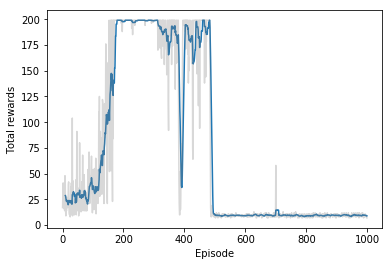

In [35]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

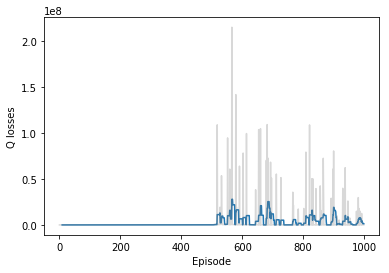

In [36]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

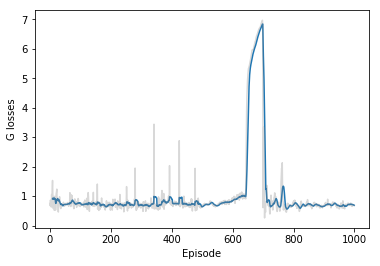

In [37]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

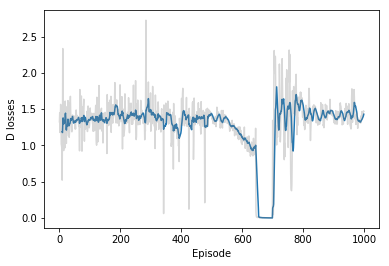

In [38]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [39]:
test_episodes = 5
test_max_steps = 200
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    saver.restore(sess, 'checkpoints/Q-GAN-cartpole.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            #env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

# Closing the env
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/Q-GAN-cartpole.ckpt


## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.